# Modules import

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

import glob
import time
import gc

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label


# 1. Function definition

### 1.1. Auxiliary functions for feature extraction

In [2]:

# Read image file as RGB with pixel color channel intensities of type np.uint8 in [0,255] range
# It handles both jpg and png formats
def readImage(file):
    iFind = file.find('png', -3)
    # case png file
    if iFind is not -1:
        return np.uint8( 255*mpimg.imread(file) )
    # else, assume it is jpg, already scaled to [0,255] by mpimg.imread()
    else:
        return mpimg.imread(file)

# Transform image color space
# Input image shall be in RGB color space
def transform_colorSpace(img, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    return feature_image
    

# Compute binned color features  
def bin_spatial_features(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 


# Compute color histogram features 
def color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))


# Calculate HOG features and  return features and, optionally, visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features


# Extract features from a single image
# Input image shall be in RGB color space
def extract_features_singleImage(
    img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
    pix_per_cell=8, cell_per_block=2, hog_channel=0,
    spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion
    feature_image = transform_colorSpace(img, color_space)
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial_features(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist_features(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append( get_hog_features(feature_image[:,:,channel],
                    orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True) )
            hog_features = np.ravel(hog_features)
        elif hog_channel == '-2':
            hog_features = []
            hog_features.append( get_hog_features(feature_image[:,:,-2],
                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True) )
            hog_features.append( get_hog_features(feature_image[:,:,-1],
                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True) )
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)


### 2.2. Auxiliary functions for detection windows

In [3]:

# Draw input boxes on input image
# Input boxes given as ((p1x,p1y), (p2x,p2y)), with p1 and p2 being two opposite corners
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Generate list of search windows of a single size within a given image region
# and with given overlap
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0]==None: x_start_stop[0]=0
    if x_start_stop[1]==None: x_start_stop[1]=img.shape[1]
    if y_start_stop[0]==None: y_start_stop[0]=0
    if y_start_stop[1]==None: y_start_stop[1]=img.shape[0]
    
    # Compute the span of the region to be searched
    spanx = x_start_stop[1]-x_start_stop[0]
    spany = y_start_stop[1]-y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    stepx = np.int( xy_window[0]*(1-xy_overlap[0]) )
    stepy = np.int( xy_window[1]*(1-xy_overlap[1]) )

    # Compute the number of windows in x/y
    numwindx = np.int( (spanx-xy_overlap[0]*xy_window[0])/stepx )
    numwindy = np.int( (spany-xy_overlap[1]*xy_window[1])/stepy )
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for iy in range(numwindy):
        for ix in range(numwindx):
            # Calculate each window position
            startx = x_start_stop[0] + ix*stepx
            starty = y_start_stop[0] + iy*stepy
            endx = startx + xy_window[0]
            endy = starty + xy_window[1]
            # append window to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Generate a list of search windows at different scales
def slide_windows_multiScale(img, withOverlap=True, debugInfo=False):
        
    if withOverlap:
        overlaps = [0.8, 0.9 ]
    else:
        overlaps = [ 0., 0. ]
    
    # 128x128 pixel windows
    bboxes128 = slide_window(
        img, x_start_stop=[None, None], y_start_stop=[360, 550],
        xy_window=(128, 128), xy_overlap=(overlaps[0],overlaps[0]) )    

    # 96x96 pixel windows
    bboxes96 = slide_window(
        img, x_start_stop=[None, None], y_start_stop=[400, 520],
        xy_window=(96, 96), xy_overlap=(overlaps[1],overlaps[1]) )
    
    # 64x64 pixel windows
    bboxes64 = slide_window(
        img, x_start_stop=[None, None], y_start_stop=[380, 500],
        xy_window=(64, 64), xy_overlap=(overlaps[0],overlaps[0]) )
    
    bboxes = bboxes128+bboxes96+bboxes64
    
    if debugInfo:
        imgProcessed = img
        imgProcessed = draw_boxes(imgProcessed, bboxes64, color=(0, 255, 0), thick=2)
        imgProcessed = draw_boxes(imgProcessed, bboxes128, color=(0, 0, 255), thick=2)
        imgProcessed = draw_boxes(imgProcessed, bboxes96, color=(150, 150, 0), thick=2)
        plt.imshow(imgProcessed)
        plt.title('Search windows')
        plt.axis('off')
        plt.show()
        #plt.savefig('output_images/search_windows.jpg', bbox_inches='tight')
        print(len(bboxes), 'windows searched per image')
    
    return bboxes


# Classify input windows of input image as car or no-cars
# A list with all input windows identified as containing a car is returned
# Input windows shall be the output of slide_windows()
def search_windows(
    img, windows, clf, scaler, clf_pixel_size=(64, 64), color_space='RGB',
    spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8,
    cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(
            img[window[0][1]:window[1][1], window[0][0]:window[1][0]], clf_pixel_size)      
        
        # Extract features for that window
        features = extract_features_singleImage(
            test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Normalize features
        normalized_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Infer class with classifier
        prediction = clf.predict(normalized_features)
        
        # If car, save the window
        if prediction == 1:
            on_windows.append(window)

    return on_windows


# Add contribution of input boundary box list to heatmap
# Heatmap shall be initialized to a np.array of zeros of shape (nrows,ncols)
# before first call to add_heat
def add_heat(heatmap, windows_list):

    for box in windows_list:
        # Add += 1 for all pixels inside each window
        # Assuming each "window" takes the form ((x1, y1), (x2, y2)),
        # with x1<x2 and y1>y2, i.e. first element is top-left corner,
        # and second element is bottom-right corner
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap


# Create a detection heatmap from input list of windows thought to contain cars
def createHeatmap(windows_list, imshape):
    
    #print('creating heatmap from {} windows'.format(len(windows_list)))
    
    heatmap = np.zeros((imshape[0:2]), dtype=np.float)
    
    for box in windows_list:
        # Add += 1 for all pixels inside each window
        # Assuming each "window" takes the form ((x1, y1), (x2, y2)),
        # with x1<x2 and y1>y2, i.e. first element is top-left corner,
        # and second element is bottom-right corner
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap


# Apply threshold to input heatmap, zeroing out pixels below input threshold
# Values are also clipped to [0,255] range so that heatmap can be plotted with plt.imshow()
def apply_threshold(heatmap, threshold):
    heatmapThr = np.copy(heatmap)
    heatmapThr[heatmapThr < threshold] = 0
    return np.clip(heatmapThr, 0, 255)


# Extract boundary boxes of individual cars from input heatmap,
# and draw them on input image if box height-to-width ratio and dimensions are within expected thresholds
def compute_and_draw_labeled_bboxes(img, heatmap, heightToWidthThr=(0.45, 2.2), minSideLenght=50, color=(0, 200, 50), thick=3):
    
    imgProcessed = np.copy(img)
    
    # Identify individual cars
    labels = label(heatmap)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # If window height-to-width ratio is within expected threshold and window is large enough, draw box
        h = bbox[1][1]-bbox[0][1]
        w = bbox[1][0]-bbox[0][0]
        heightToWidth = h/w
        if h>minSideLenght and w>minSideLenght and heightToWidth>heightToWidthThr[0] and heightToWidth<heightToWidthThr[1]:
            cv2.rectangle(imgProcessed, bbox[0], bbox[1], color, thick)
    
    # Return the image
    return imgProcessed


### 2.3. Functions for video processing pipeline

In [4]:

# Class to share data about windows detection between consecutive processing cycles
class Windows():
    def __init__(self):
        
        # Number of windows detected in each of the last iNumFramesTracked cycles
        self.numWindows = []
        
        # Coordinates of all windows detected in the last iNumFramesTracked cycles
        self.bboxes = []


# Final processing pipeline
# Before calling 'process_video_config' for the first time, object 'process_video.windows'
# of class 'Windows' needs to be constructed
def process_video_config(img, iNumFramesTracked, iHeatmapThreshold, heightToWidthThr, minSideLength, debugInfo=False):
    
    windows = slide_windows_multiScale(img, withOverlap=True, debugInfo=False)
    
    # detect windows containing cars in this video frame
    on_windows = search_windows(
        img, windows, svc, X_scaler, (64, 64), color_space,
        spatial_size, hist_bins, (0, 256), orient, pix_per_cell,
        cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

    # add windows thought to contain a car in this frame at the front of list of windows
    # thought to contain cars in last iNumFramesTracked frames
    process_video.windows.bboxes = on_windows + process_video.windows.bboxes
    process_video.windows.numWindows.insert(0, len(on_windows))
    
    # if number of frames tracked exceeds iNumFramesTracked, remove info of oldest frame
    if len(process_video.windows.numWindows) > iNumFramesTracked:
        
        for i in range(process_video.windows.numWindows[-1]):
            process_video.windows.bboxes.pop()
        
        process_video.windows.numWindows.pop()
    
    # create heatmap of detections in last iNumFramesTracked frames
    heatmap = createHeatmap(process_video.windows.bboxes, img.shape)

    # apply thresholding to filter out false positives
    heatmapThr = apply_threshold(heatmap, threshold=iHeatmapThreshold)

    # identify individual cars and draw boundary boxes on original image
    imgLabeled = compute_and_draw_labeled_bboxes(img, heatmapThr, heightToWidthThr, minSideLength, color=(0, 200, 50), thick=3)
    
    if debugInfo:
        
        img = draw_boxes(img, process_video.windows.bboxes, color=(0, 0, 255), thick=2)
        plt.imshow( draw_boxes(img, on_windows, color=(0, 255, 0), thick=3) )
        plt.axis('off')
        plt.title('Windows with detection (in green detections in this frame)')
        plt.show()
        
        #plt.imshow(heatmap, cmap='YlOrRd')
        #plt.title("Car detection heatmap before thresholding")
        #plt.show()

        plt.imshow(heatmapThr, cmap='YlOrRd')
        plt.axis('off')
        plt.title("Car detection heatmap after thresholding")
        plt.show()
        
        labels = label(heatmapThr)
        #print(labels[1], 'cars found')
        plt.imshow(labels[0], cmap='gray')
        plt.axis('off')
        plt.title('Labels')
        plt.show()
        
        plt.imshow(imgLabeled)
        plt.axis('off')
        plt.title('Processed image')
        plt.show()        

    return imgLabeled


# This is simply a wrapper of 'process_video_config' with a single input argument,
# as required by moviepy.editor.VideoFileClip.fl_image()
def process_video(img):
    
    return process_video_config(img, iNumFramesTracked, iHeatmapThreshold, heightToWidthThr, minSideLength, debugInfo)

# 3. Import and explore data

### 3.1. Collect lists of image files for training and testing datasets 

In [5]:

testFraction = 0.15


# Fill in list of training and test car images -----
carImageFilesTrain = []
carImageFilesTest = []

imageFiles = glob.glob('./vehicles/GTI_Far/*.png')
numTrainImages = int((1-testFraction)*len(imageFiles))
for i in range( numTrainImages ):
    carImageFilesTrain.append( imageFiles[i] )
for i in range( numTrainImages, len(imageFiles) ):
    carImageFilesTest.append( imageFiles[i] )

imageFiles = glob.glob('./vehicles/GTI_Left/*.png')
numTrainImages = int((1-testFraction)*len(imageFiles))
for i in range( numTrainImages ):
    carImageFilesTrain.append( imageFiles[i] )
for i in range( numTrainImages, len(imageFiles) ):
    carImageFilesTest.append( imageFiles[i] )

imageFiles = glob.glob('./vehicles/GTI_Right/*.png')
numTrainImages = int((1-testFraction)*len(imageFiles))
for i in range( numTrainImages ):
    carImageFilesTrain.append( imageFiles[i] )
for i in range( numTrainImages, len(imageFiles) ):
    carImageFilesTest.append( imageFiles[i] )
    
imageFiles = glob.glob('./vehicles/GTI_MiddleClose/*.png')
numTrainImages = int((1-testFraction)*len(imageFiles))
for i in range( numTrainImages ):
    carImageFilesTrain.append( imageFiles[i] )
for i in range( numTrainImages, len(imageFiles) ):
    carImageFilesTest.append( imageFiles[i] )
    
imageFiles = glob.glob('./vehicles/KITTI_extracted/*.png')
aRand = np.random.rand(len(imageFiles))
for i in range(len(imageFiles)):
    if aRand[i]>testFraction:
        carImageFilesTrain.append( imageFiles[i] )
    else:
        carImageFilesTest.append( imageFiles[i] )


# Fill in list of training and test non-car images -----
noncarImageFilesTrain = []
noncarImageFilesTest = []
        
imageFiles = glob.glob('./non-vehicles/GTI/*.png')
numTrainImages = int((1-testFraction)*len(imageFiles))
for i in range( numTrainImages ):
    noncarImageFilesTrain.append( imageFiles[i] )
for i in range( numTrainImages, len(imageFiles) ):
    noncarImageFilesTest.append( imageFiles[i] )

imageFiles = glob.glob('./non-vehicles/Extras/*.png')
numTrainImages = int((1-testFraction)*len(imageFiles))
for i in range( numTrainImages ):
    noncarImageFilesTrain.append( imageFiles[i] )
for i in range( numTrainImages, len(imageFiles) ):
    noncarImageFilesTest.append( imageFiles[i] )
    

In [6]:
# Define training and test labels
# 1 if car, 0 if non-car
y_train = np.hstack((
    np.ones(len(carImageFilesTrain)),
    np.zeros(len(noncarImageFilesTrain)) ))

y_test = np.hstack((
    np.ones(len(carImageFilesTest)),
    np.zeros(len(noncarImageFilesTest)) ))


print("Number of training images ---")
print("  ", len(carImageFilesTrain), "car images")
print("  ", len(noncarImageFilesTrain), "non-car images")
print("  ", len(carImageFilesTrain)+len(noncarImageFilesTrain),
      "total ({:.2f} %)".format(100*len(y_train)/(len(y_train)+len(y_test))) )

print("\nNumber of test images ---")
print("  ", len(carImageFilesTest), "car images")
print("  ", len(noncarImageFilesTest), "non-car images")
print("  ", len(carImageFilesTest)+len(noncarImageFilesTest),
      "total ({:.2f} %)".format(100*len(y_test)/(len(y_train)+len(y_test))) )


Number of training images ---
   7466 car images
   7622 non-car images
   15088 total (84.95 %)

Number of test images ---
   1326 car images
   1346 non-car images
   2672 total (15.05 %)


### 3.2. Plot example dataset images


Image properties after type and range conversion:
image shape : (64, 64, 3)
image type : uint8
min pixel intensity : 4
max pixel intensity : 255



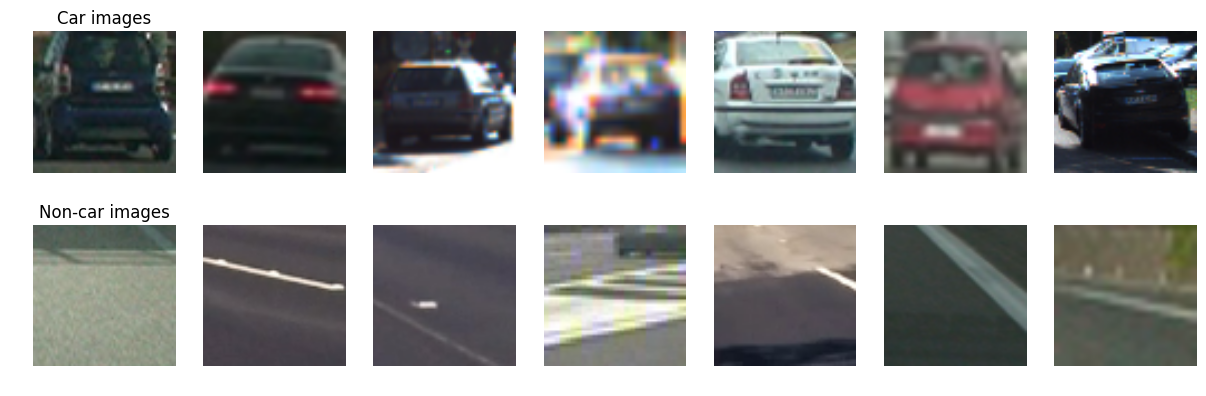

In [7]:

# Select random car and non-car images
indecesCar = np.random.choice(range(len(carImageFilesTrain)), 7)
indecesNoncar = np.random.choice(range(len(noncarImageFilesTrain)), 7)


print('\nImage properties after type and range conversion:')
file = carImageFilesTrain[indecesCar[0]]
img = readImage(file)
print("image shape :", img.shape)
print("image type :", img.dtype)
print("min pixel intensity :", img.min())
print("max pixel intensity :", img.max())
print()


f, axarr = plt.subplots(2,7, figsize=(15,5))

for i in range(len(indecesCar)):
    index = indecesCar[i]
    file = carImageFilesTrain[index]
    img = readImage(file)
    axarr[0,i].imshow(img)
    axarr[0,i].axis('off')

for i in range(len(indecesNoncar)):
    index = indecesNoncar[i]
    file = noncarImageFilesTrain[index]
    img = readImage(file)
    axarr[1,i].imshow(img)
    axarr[1,i].axis('off')

axarr[0,0].set_title('Car images')
axarr[1,0].set_title('Non-car images')
plt.axis('off')
f.subplots_adjust(hspace=0)

plt.savefig('output_images/exampleTrainingImages.jpg', bbox_inches='tight')
plt.show()


# 4. Feature extraction, pre-processing and classifier training

## 4.1. Explore features

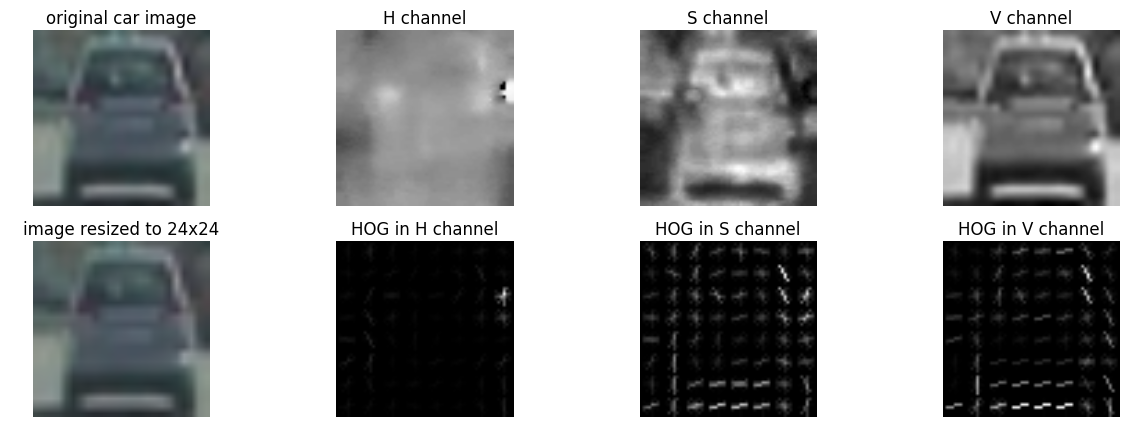

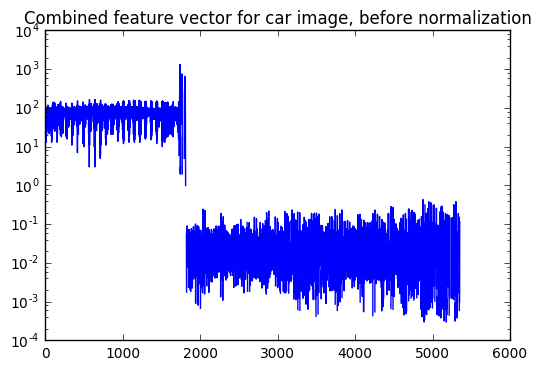

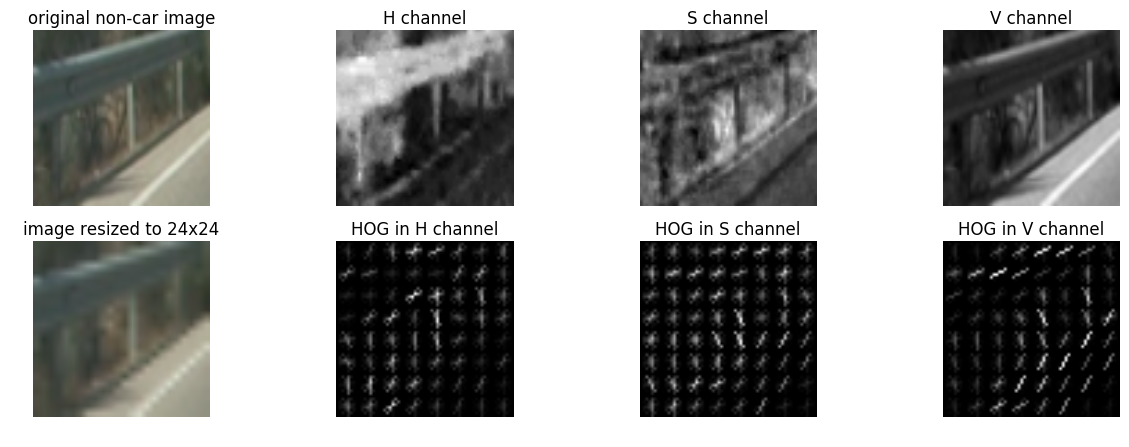

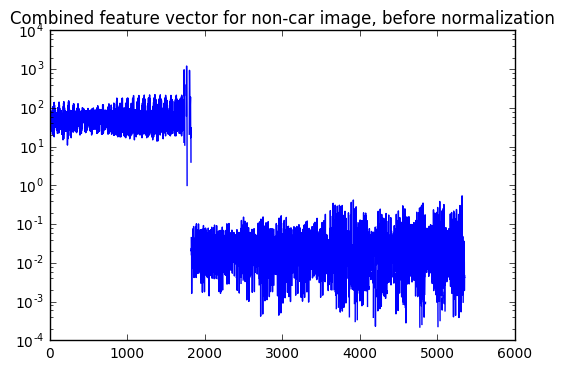

In [8]:

# feature extraction tunning, as per processing pipeline
color_space = 'HSV'      # RGB, HSV, LUV, HLS, YUV or YCrCb
orient = 9               # number of HOG orientation bins
pix_per_cell = 8         # HOG pixels per cell
cell_per_block = 2       # HOG cells per block
hog_channel = '-2'       # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24)  # Image dimensions for spatial binning
hist_bins = 32           # Number of color histogram bins
spatial_feat = True      # Spatial bin features on or off
hist_feat = True         # Histogram features on or off
hog_feat = True          # HOG features on or off


# Explore features for car image -------------------------------------------------

# read image
img = readImage( carImageFilesTrain[5] )

# transform color space
imgHSV = transform_colorSpace(img, color_space)

# extract HOG features for H channel
features, imgHogH = get_hog_features(
    imgHSV[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# extract HOG features for S channel
features, imgHogS = get_hog_features(
    imgHSV[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# extract HOG features for V channel
features, imgHogV = get_hog_features(
    imgHSV[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# resize image as for spatial binning
imgResized = cv2.resize(img, spatial_size)

# extract all features
features = extract_features_singleImage(
    img, color_space, spatial_size, hist_bins, orient, 
    pix_per_cell, cell_per_block, hog_channel,
    spatial_feat, hist_feat, hog_feat)

# plot color channels and HOG features
f, axarr = plt.subplots(2,4, figsize=(15,5))
axarr[0,0].imshow(img)
axarr[0,0].set_title('original car image')
axarr[0,1].imshow(imgHSV[:,:,0], cmap='gray')
axarr[0,1].set_title('H channel')
axarr[0,2].imshow(imgHSV[:,:,1], cmap='gray')
axarr[0,2].set_title('S channel')
axarr[0,3].imshow(imgHSV[:,:,2], cmap='gray')
axarr[0,3].set_title('V channel')
axarr[1,0].imshow(imgResized)
axarr[1,0].set_title('image resized to 24x24')
axarr[1,1].imshow(imgHogH, cmap='gray')
axarr[1,1].set_title('HOG in H channel')
axarr[1,2].imshow(imgHogS, cmap='gray')
axarr[1,2].set_title('HOG in S channel')
axarr[1,3].imshow(imgHogV, cmap='gray')
axarr[1,3].set_title('HOG in V channel')
for i in range(2):
    for j in range(4):
        axarr[i,j].axis('off')
plt.savefig('output_images/carHogFeatures.jpg', bbox_inches='tight')
plt.show()

# plot full feature vector
plt.plot(features)
plt.semilogy()
plt.title('Combined feature vector for car image, before normalization')
plt.savefig('output_images/carFeatureVector.jpg', bbox_inches='tight')
plt.show()



# Explore features for non-car image -------------------------------------------------

# read image
img = readImage( noncarImageFilesTrain[5] )

# transform color space
imgHSV = transform_colorSpace(img, color_space)

# extract HOG features for H channel
features, imgHogH = get_hog_features(
    imgHSV[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# extract HOG features for S channel
features, imgHogS = get_hog_features(
    imgHSV[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# extract HOG features for V channel
features, imgHogV = get_hog_features(
    imgHSV[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# resize image as for spatial binning
imgResized = cv2.resize(img, spatial_size)

# extract all features
features = extract_features_singleImage(
    img, color_space, spatial_size, hist_bins, orient, 
    pix_per_cell, cell_per_block, hog_channel,
    spatial_feat, hist_feat, hog_feat)

# plot color channels and HOG features
f, axarr = plt.subplots(2,4, figsize=(15,5))
axarr[0,0].imshow(img)
axarr[0,0].set_title('original non-car image')
axarr[0,1].imshow(imgHSV[:,:,0], cmap='gray')
axarr[0,1].set_title('H channel')
axarr[0,2].imshow(imgHSV[:,:,1], cmap='gray')
axarr[0,2].set_title('S channel')
axarr[0,3].imshow(imgHSV[:,:,2], cmap='gray')
axarr[0,3].set_title('V channel')
axarr[1,0].imshow(imgResized)
axarr[1,0].set_title('image resized to 24x24')
axarr[1,1].imshow(imgHogH, cmap='gray')
axarr[1,1].set_title('HOG in H channel')
axarr[1,2].imshow(imgHogS, cmap='gray')
axarr[1,2].set_title('HOG in S channel')
axarr[1,3].imshow(imgHogV, cmap='gray')
axarr[1,3].set_title('HOG in V channel')
for i in range(2):
    for j in range(4):
        axarr[i,j].axis('off')
plt.savefig('output_images/noncarHogFeatures.jpg', bbox_inches='tight')
plt.show()


# plot full feature vector
plt.plot(features)
plt.semilogy()
plt.title('Combined feature vector for non-car image, before normalization')
plt.savefig('output_images/noncarFeatureVector.jpg', bbox_inches='tight')
plt.show()



## 4.2. Extract features

In [9]:

# Feature extraction parameters

color_space = 'HSV'      # RGB, HSV, LUV, HLS, YUV or YCrCb
orient = 9               # number of HOG orientation bins
pix_per_cell = 8         # HOG pixels per cell
cell_per_block = 2       # HOG cells per block
hog_channel = '-2'       # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24)  # Image dimensions for spatial binning
hist_bins = 32           # Number of color histogram bins
spatial_feat = True      # Spatial bin features on or off
hist_feat = True         # Histogram features on or off
hog_feat = True          # HOG features on or off


X_train = []
X_test = []

# For file in training dataset

print("\nExtracting features for training dataset ({} examples) ..."
      .format(len(carImageFilesTrain)+len(noncarImageFilesTrain)))
t = time.time()

i = 0
for file in np.concatenate((carImageFilesTrain, noncarImageFilesTrain)):
    
    if i%1000==0:
        print("  example", i+1, "...")
    i+=1
    
    # Read image as RGB, scale intensities to [0-255] range and transform to uint8
    img = readImage(file)
    
    # Extract image features and append to feature list
    X_train.append( extract_features_singleImage( img, color_space, spatial_size,
        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat,                            
        hist_feat, hog_feat ) )

t2 = time.time()
print("\nFeature extraction duration : {:.0f} s".format(t2-t))
    
    
# For file in test dataset

print("\nExtracting features for test dataset ({} examples) ..."
      .format( len(carImageFilesTest)+len(noncarImageFilesTest) ))
t = time.time()

i = 0
for file in np.concatenate((carImageFilesTest, noncarImageFilesTest)):
    
    if i%1000==0:
        print("  example", i+1, "...")
    i+=1
    
    # Read image as RGB, scale intensities to [0-255] range and transform to uint8
    img = readImage(file)
    
    # Extract image features and append to feature list
    X_test.append( extract_features_singleImage( img, color_space, spatial_size,
        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat,                            
        hist_feat, hog_feat ) )

t2 = time.time()
print("\nFeature extraction duration : {:.0f} s".format(t2-t))
    
print("\nnumber of features in feature vector :", len(X_train[0]))
    


Extracting features for training dataset (15088 examples) ...
  example 1 ...
  example 1001 ...
  example 2001 ...
  example 3001 ...
  example 4001 ...
  example 5001 ...
  example 6001 ...
  example 7001 ...
  example 8001 ...
  example 9001 ...
  example 10001 ...
  example 11001 ...
  example 12001 ...
  example 13001 ...
  example 14001 ...
  example 15001 ...

Feature extraction duration : 255 s

Extracting features for test dataset (2672 examples) ...
  example 1 ...
  example 1001 ...
  example 2001 ...

Feature extraction duration : 41 s

number of features in feature vector : 5352


### 4.3. Normalize features

In [10]:

# Convert data to float64 before calling StandardScaler
X_train = np.float64(X_train)
X_test = np.float64(X_test)


# Fit a per-column scaler with the training dataset only
# (test dataset shall only be used to evaluate the trained model)
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training and test datasets
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


# Check that training features have zero mean and unit variance
# Test features should also have about zero mean and unit variance
print("X_train.mean() :", X_train.mean())
print("X_train.var() :", X_train.var())
print("X_test.mean() :", X_test.mean())
print("X_test.var() :", X_test.var())


X_train.mean() : -2.25899703635e-17
X_train.var() : 0.99831838565
X_test.mean() : 0.0172706089424
X_test.var() : 1.12014896986


### 4.4. Shuffle the training dataset

In [11]:
# Randomly shuffle training dataset

shuffledIndices = np.arange(len(y_train))
np.random.shuffle(shuffledIndices)

X_train = X_train[shuffledIndices]
y_train = y_train[shuffledIndices]

label: 0.0


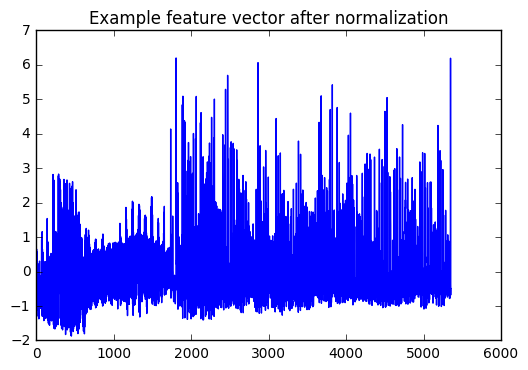

In [12]:
i = np.random.randint(0,len(X_train))

print("label:", y_train[i])
plt.plot(X_train[i])
plt.title('Example feature vector after normalization')
plt.show()

### 4.5. Train  and evaluate a Support Vector Machine Classifier

In [13]:

# Define linear SVC
svc = LinearSVC(C=1e-4, dual=False)

# Train classifier
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("Trainig duration :", round(t2-t, 2), "seconds")

# Evaluate classifier with test set
print('Training Accuracy :', round(svc.score(X_train, y_train), 4))
print('Test Accuracy :', round(svc.score(X_test, y_test), 4))


Trainig duration : 10.84 seconds
Training Accuracy : 0.998
Test Accuracy : 0.9869


In [14]:
# free memory

del X_train
del X_test
del y_train
del y_test

gc.collect()

19794

# 5. Sliding windows search

### 5.1. Test definition of search windows and search in windows

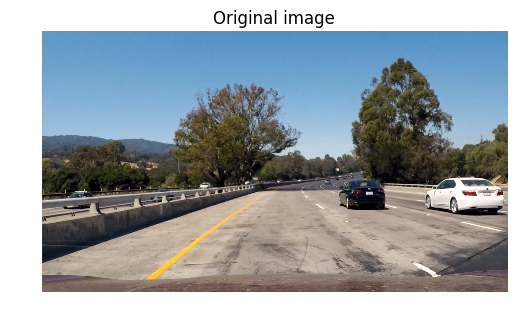

image shape : (720, 1280, 3)


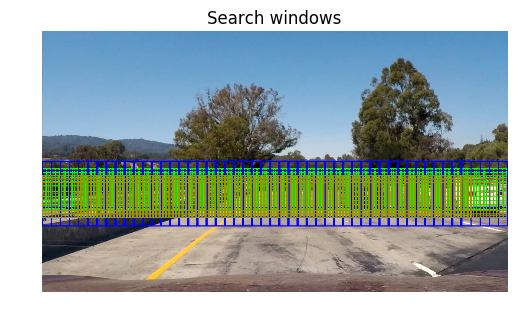

1047 windows searched per image
processing time for window detection in frame : 5.3 s


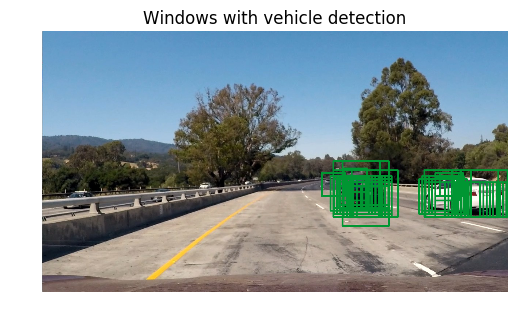

   68  windows detected


In [15]:

# import test image
imageFile = './test_images/test1.jpg'

img = plt.imread(imageFile)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')
plt.savefig('output_images/original_image.jpg', bbox_inches='tight')
plt.show()

imshape = img.shape
print("image shape :", imshape)

# compute and plot search windows
windows = slide_windows_multiScale(img, withOverlap=True, debugInfo=True)

# identify search windows containing vehicle
t0 = time.time()

on_windows = search_windows(
    img, windows, svc, X_scaler, (64, 64), color_space,
    spatial_size, hist_bins, (0, 256), orient, pix_per_cell,
    cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

t1 = time.time()
print('processing time for window detection in frame :', round(t1-t0,2), 's')

# draw boxes with vehicle detection on original image
imgProcessed = draw_boxes(img, on_windows, color=(0, 150, 50), thick=3)

plt.imshow(imgProcessed)
plt.title('Windows with vehicle detection')
plt.axis('off')
plt.savefig('output_images/on_windows.jpg', bbox_inches='tight')
plt.show()

print('  ', len(on_windows), ' windows detected')

### 5.2. Run search in windows algorithm in all test images

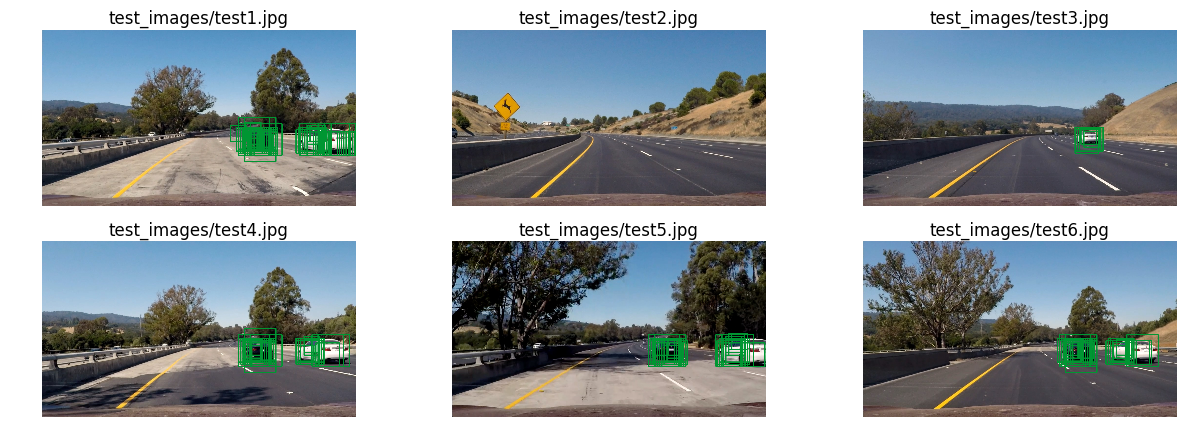

In [16]:
testImageFiles = ['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 
                  'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']

f, axarr = plt.subplots(2,3, figsize=(15,5))

i=0
j=0

for imageFile in testImageFiles:

    img = readImage(imageFile)
    
    # compute and plot search windows
    windows = slide_windows_multiScale(img, withOverlap=True, debugInfo=False)

    on_windows = search_windows(
        img, windows, svc, X_scaler, (64, 64), color_space,
        spatial_size, hist_bins, (0, 256), orient, pix_per_cell,
        cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

    # draw boxes with vehicle detection on original image
    imgProcessed = draw_boxes(img, on_windows, color=(0, 150, 50), thick=3)

    # draw subplot
    axarr[i,j].imshow(imgProcessed)
    axarr[i,j].set_title(imageFile)
    axarr[i,j].axis('off')
    
    # increment indices for next subplot
    if j<2:
        j+=1
    else:
        i+=1
        j=0
    
plt.savefig('output_images/test_images_processed.jpg', bbox_inches='tight')
plt.show()

### 5.3. Run final pipeline in all test images

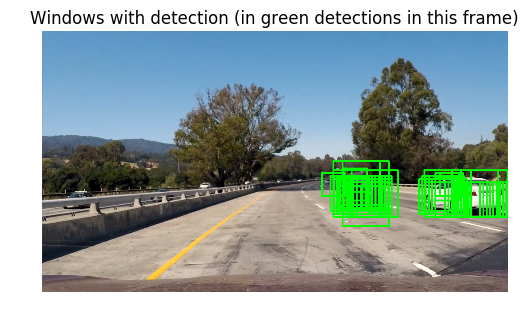

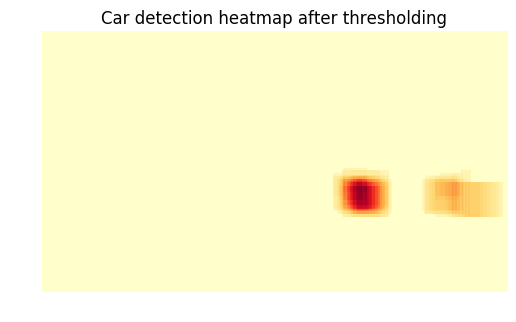

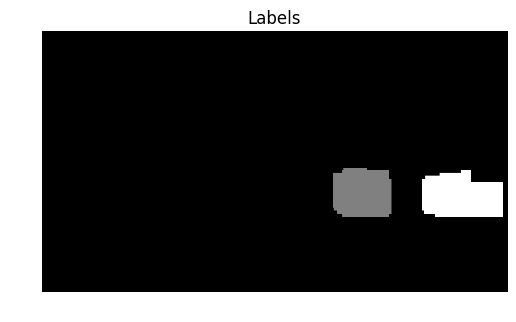

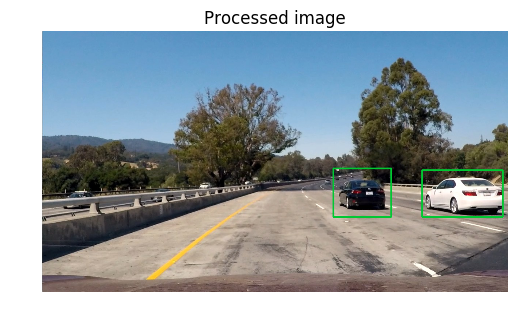

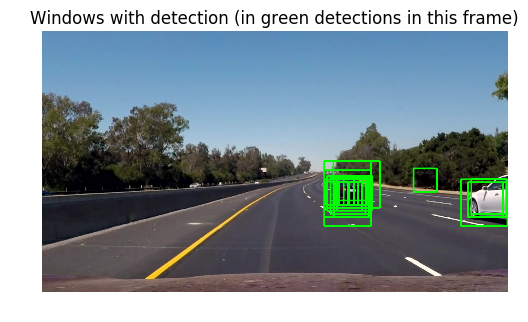

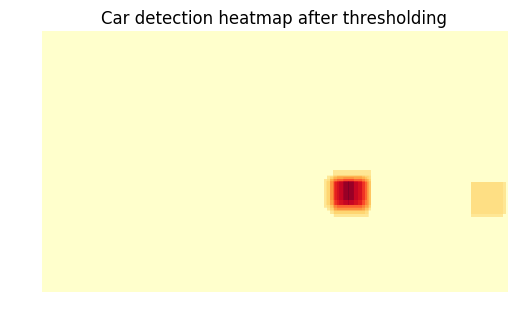

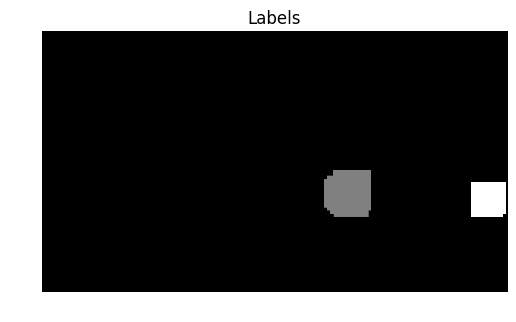

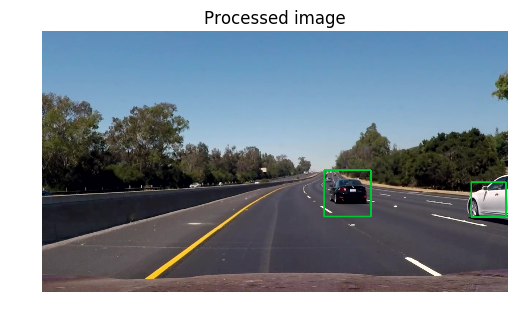

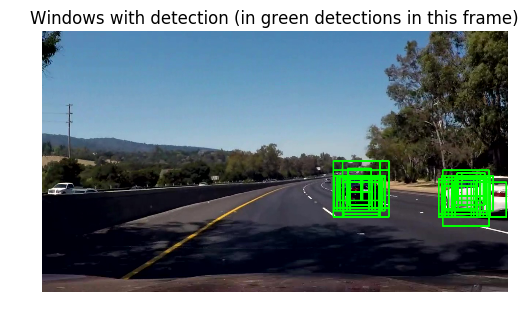

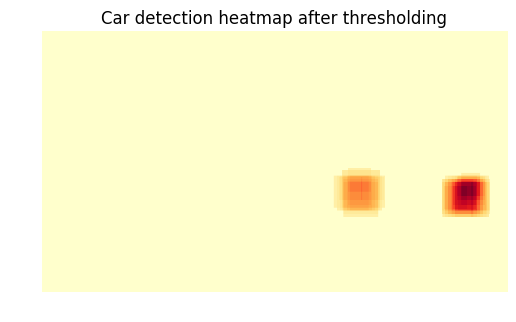

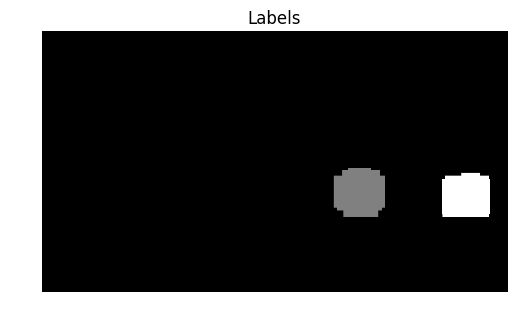

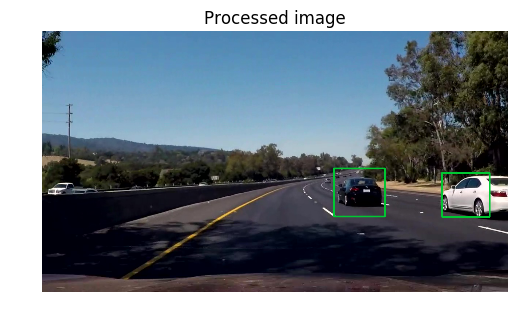

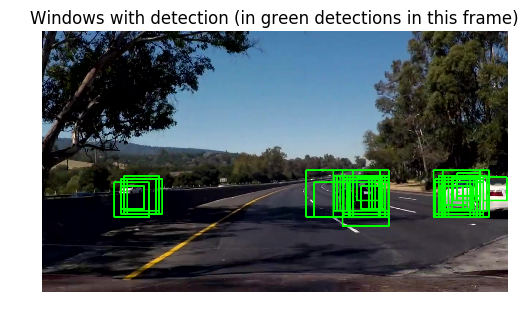

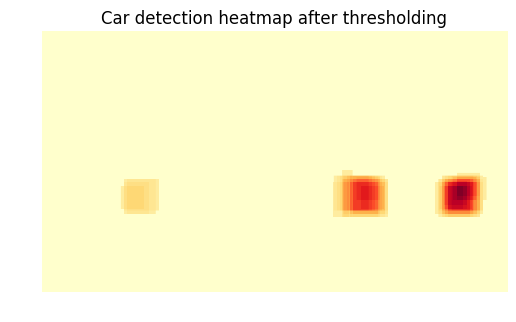

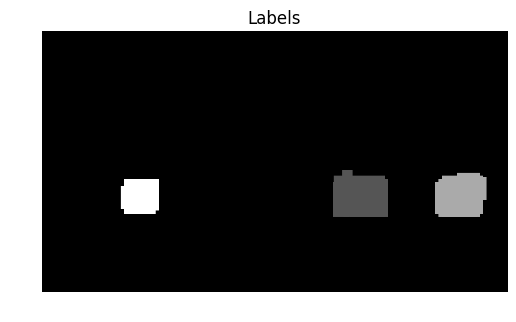

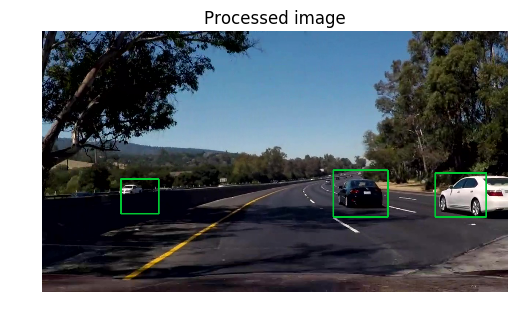

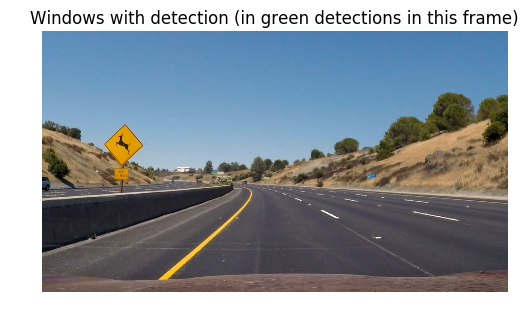

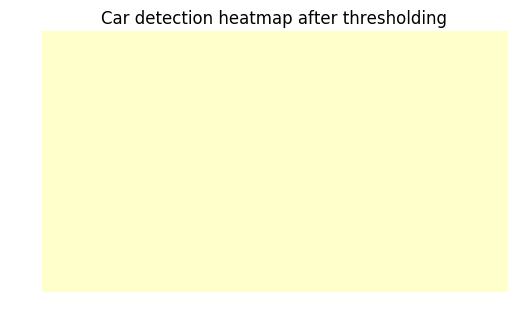

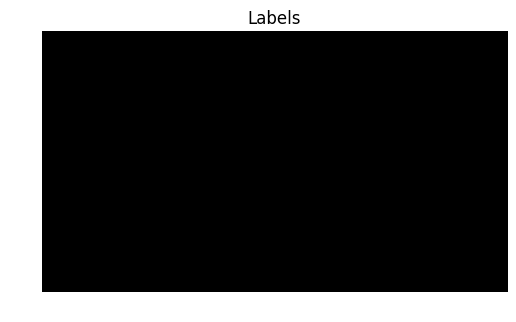

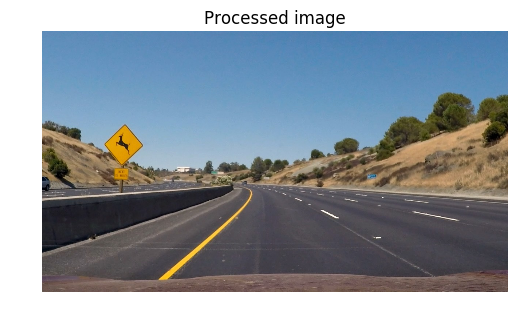

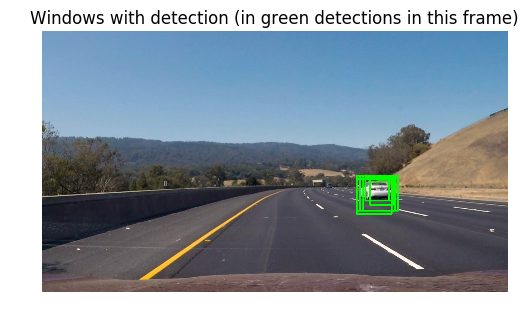

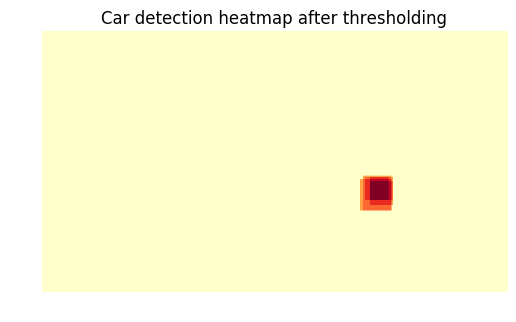

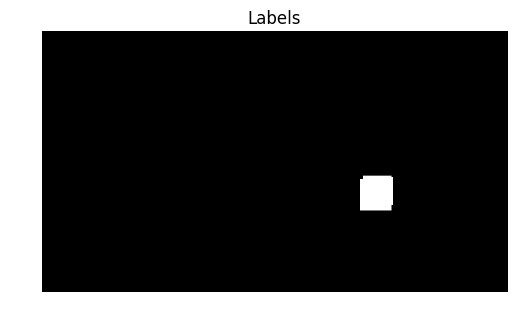

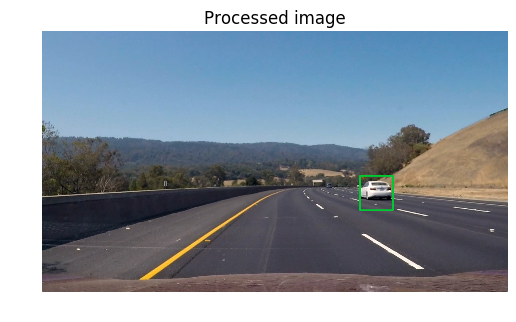

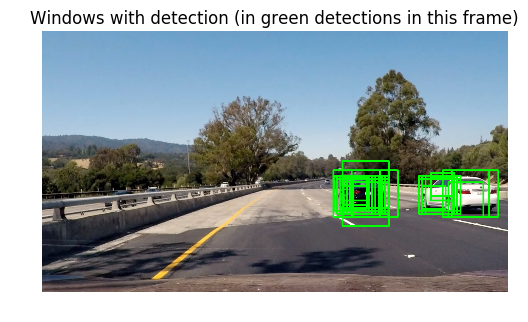

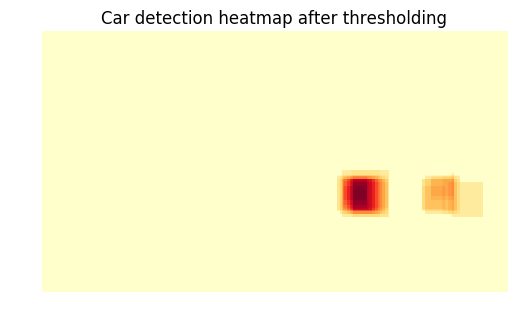

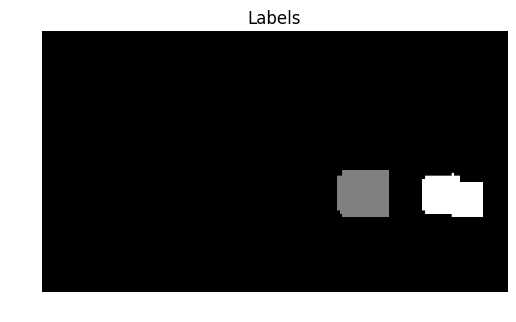

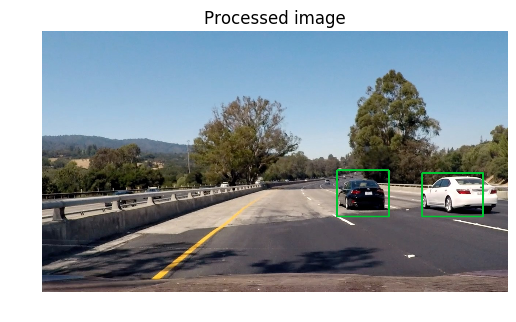

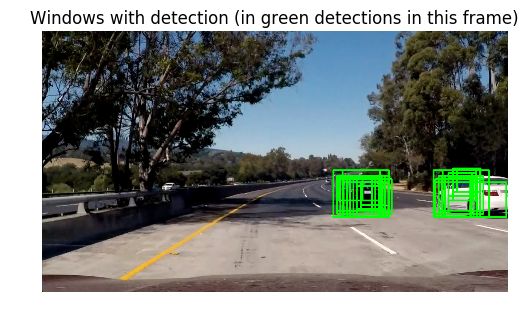

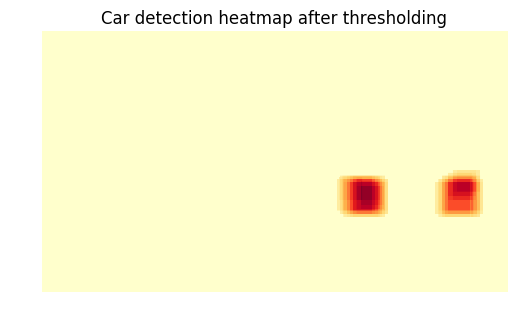

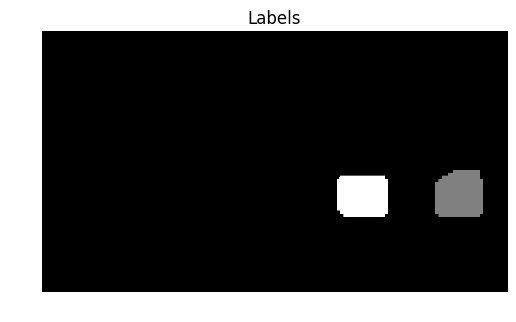

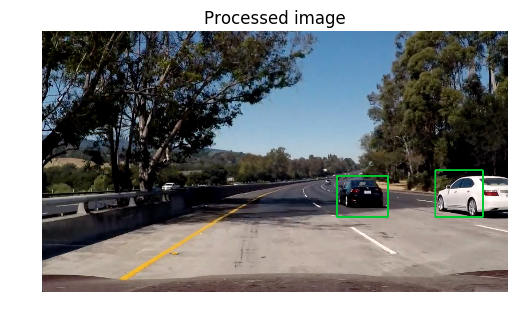

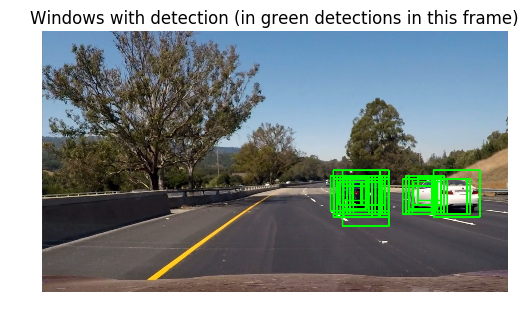

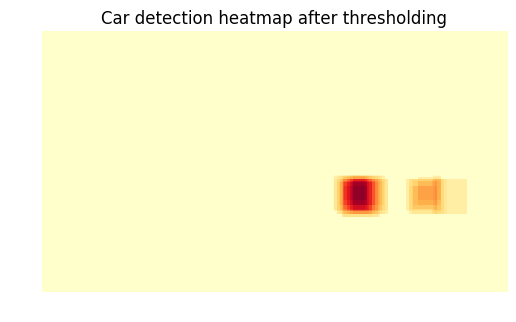

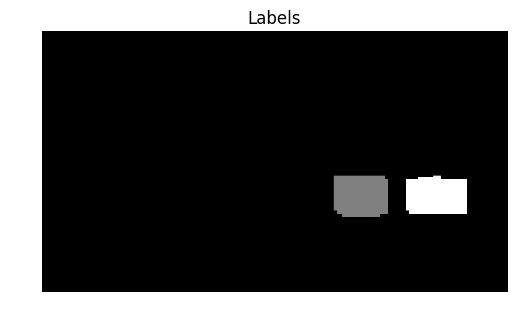

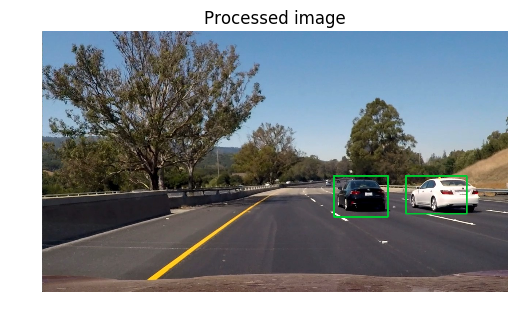

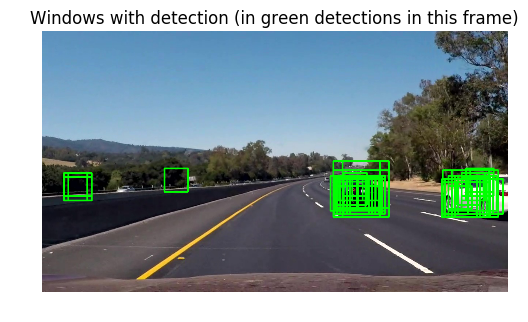

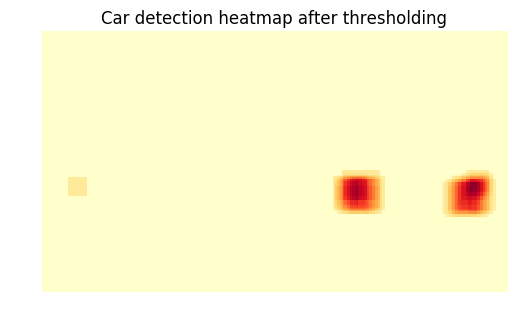

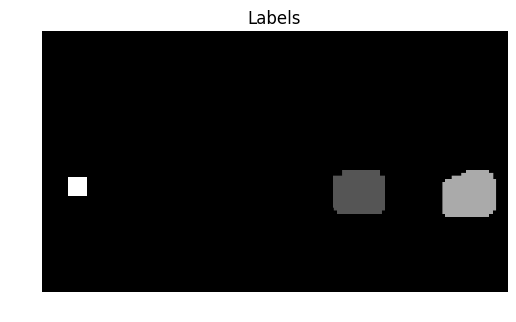

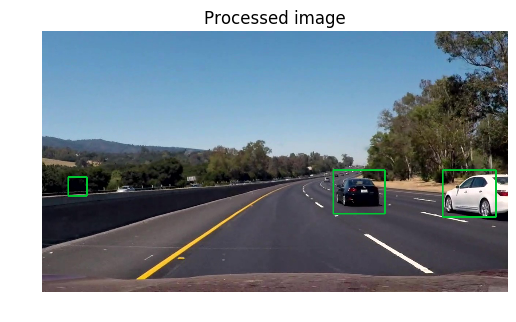

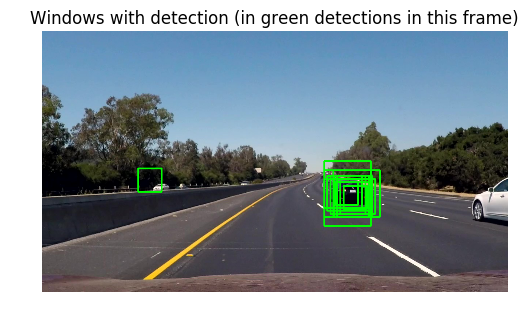

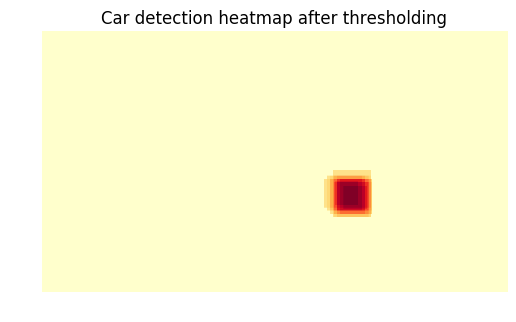

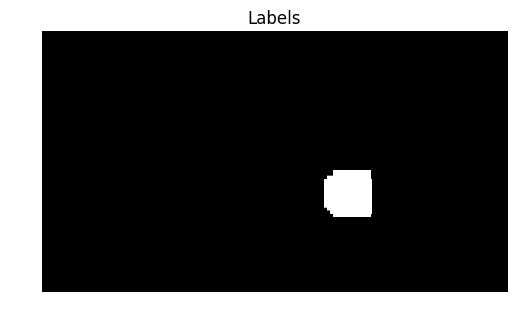

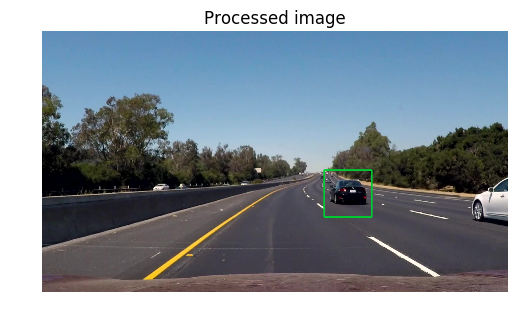

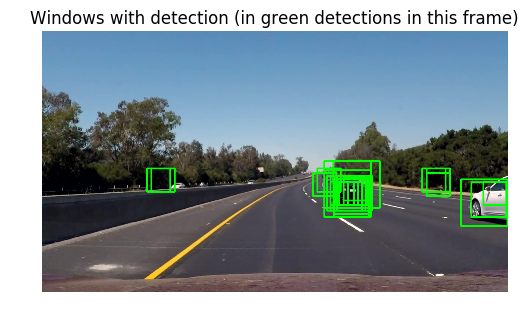

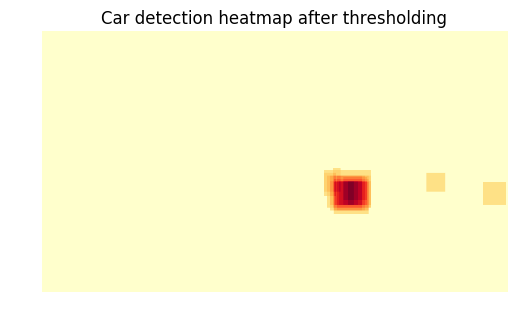

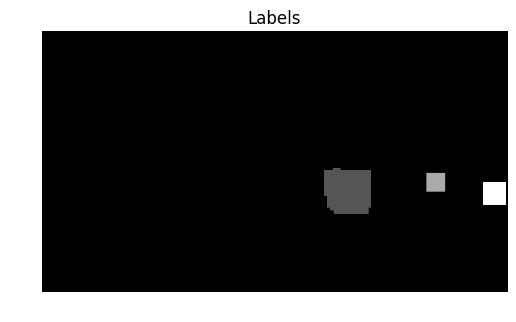

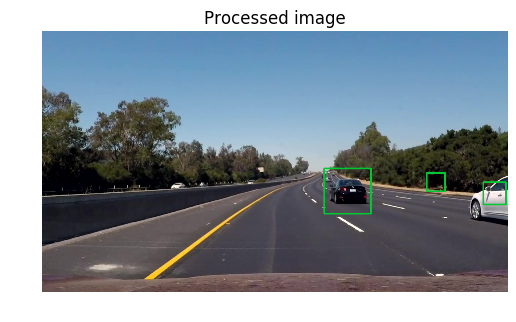

In [17]:
iNumFramesTracked = 3
iHeatmapThreshold = 3
heightToWidthThr = (0.45, 2.2)
minSideLength = 50
debugInfo = True

testImageFiles = glob.glob('test_images/test*.jpg')

for imageFile in testImageFiles:

    img = readImage(imageFile)

    # Initialize Windows object
    process_video.windows = Windows()

    # Detect car windows and plot debug info
    imgProcessed = process_video_config(img, iNumFramesTracked, iHeatmapThreshold, heightToWidthThr, minSideLength, debugInfo)
    

# 6. Run pipeline on videos

### 6.1. Download and import everything needed to edit/save/watch video clips

In [19]:
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 6.2. Process test video (with debug info for each frame)

In [ ]:
iNumFramesTracked = 3
iHeatmapThreshold = 9
heightToWidthThr = (0.33, 3.)
minSideLength = 50
debugInfo = False

output_video_filename = 'test_video_withVehicleDetection.mp4'
input_video = VideoFileClip("test_video.mp4")

# Initialize Windows object
process_video.windows = Windows()

# Process input video
output_video = input_video.fl_image(process_video)
%time output_video.write_videofile(output_video_filename, audio=False)

### 6.3. Play processed test video

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_withVehicleDetection.mp4"))

### 6.4. Process project video

In [78]:
iNumFramesTracked = 3
iHeatmapThreshold = 9
heightToWidthThr = (0.33, 3.)
minSideLength = 50
debugInfo = False

output_video_filename = 'project_video_withVehicleDetection.mp4'
input_video = VideoFileClip("project_video.mp4")

# Initialize Windows object
process_video.windows = Windows()

# Process input video
output_video = input_video.fl_image(process_video)
%time output_video.write_videofile(output_video_filename, audio=False)


[MoviePy] >>>> Building video project_video_withVehicleDetection.mp4
[MoviePy] Writing video project_video_withVehicleDetection.mp4


100%|█████████▉| 1260/1261 [1:34:10<00:04,  4.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_withVehicleDetection.mp4 

Wall time: 1h 34min 12s


### 6.5. Play processed project video

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_withVehicleDetection.mp4"))